In [ ]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 56.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 36.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 16.0 MB/s eta 0:00:00


In [ ]:
!pip install segmentation_models_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 50.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 31.4 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=fcaf5e109db086596ded90da71850e0eb139bd26c6bee170eb2b64abd25e8dae
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=e013e261585f84efbc463a9d4f5ddf8146b8c6995f06719ee47c9c4151920cf9
  Stored in directory: /root/.cache/pip/w

In [ ]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pytorch_lightning as pl
from torch import nn
from tqdm.notebook import tqdm

In [ ]:
import opendatasets as od

od.download("https://www.kaggle.com/datasets/balraj98/deepglobe-land-cover-classification-dataset", force= True)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: sgb1606
Your Kaggle Key: ··········


100%|██████████| 2.74G/2.74G [02:24<00:00, 20.3MB/s]


In [ ]:
# IMAGE_SIZE = 2448
# IMAGE_SIZE = 2464
IMAGE_SIZE = 320
BATCH_SIZE = 16
# BATCH_SIZE = 3
EPOCHS = 3

color_dict = pd.read_csv('deepglobe-land-cover-classification-dataset/class_dict.csv')
CLASSES = color_dict['name']
print(color_dict)

               name    r    g    b
0        urban_land    0  255  255
1  agriculture_land  255  255    0
2         rangeland  255    0  255
3       forest_land    0  255    0
4             water    0    0  255
5       barren_land  255  255  255
6           unknown    0    0    0


In [ ]:
from glob import glob
from sklearn.utils import shuffle

pd_dataset = pd.DataFrame({
    'IMAGES': sorted(glob("deepglobe-land-cover-classification-dataset/train/*.jpg")),
    'MASKS': sorted(glob("deepglobe-land-cover-classification-dataset/train/*.png"))
})
pd_dataset = shuffle(pd_dataset)
pd_dataset.reset_index(inplace=True, drop=True)
pd_dataset.shape

(803, 2)

In [ ]:
from sklearn.model_selection import train_test_split

pd_train, pd_test = train_test_split(pd_dataset, test_size=0.25, random_state=0)
print("Training set size:", len(pd_train))
print("Testing set size:", len(pd_test))

Training set size: 602
Testing set size: 201


In [ ]:
def rgb2category(rgb_mask):
    category_mask = np.zeros(rgb_mask.shape[:2], dtype=np.int8)
    for i, row in color_dict.iterrows():
        category_mask += (np.all(rgb_mask.reshape((-1, 3)) == (row['r'], row['g'], row['b']), axis=1).reshape(rgb_mask.shape[:2]) * i)
    return category_mask

def category2rgb(category_mask):
    rgb_mask = np.zeros(category_mask.shape[:2] + (3,))
    for i, row in color_dict.iterrows():
        rgb_mask[category_mask==i] = (row['r'], row['g'], row['b'])
    return np.uint8(rgb_mask)

In [ ]:
import albumentations as aug

train_augment = aug.Compose([
    aug.Resize(IMAGE_SIZE, IMAGE_SIZE),
    aug.HorizontalFlip(p=0.5),
    aug.VerticalFlip(p=0.5),
    aug.RandomBrightnessContrast(p=0.3)
])

test_augment = aug.Compose([
    aug.Resize(IMAGE_SIZE, IMAGE_SIZE),
    aug.RandomBrightnessContrast(p=0.3)
])

In [ ]:
class FeatureFusion(nn.Module):
    def __init__(self):
        super(FeatureFusion, self).__init__()
        self.conv10 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3)
        self.conv20 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3)
        self.conv30 = nn.Conv2d(in_channels=3 * 2, out_channels=3, kernel_size=3, padding=1)
        self.batchNorm0 = nn.BatchNorm2d(3)


        self.conv11 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1)
        self.conv21 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=1)
        self.conv31 = nn.Conv2d(in_channels=32 * 2, out_channels=32, kernel_size=1, padding=1)
        self.batchNorm1 = nn.BatchNorm2d(32)

        self.conv12 = nn.Conv2d(in_channels=224, out_channels=224, kernel_size=3)
        self.conv22 = nn.Conv2d(in_channels=256, out_channels=224, kernel_size=3)
        self.conv32 = nn.Conv2d(in_channels=224 * 2, out_channels=224, kernel_size=3, padding=1)
        self.batchNorm2 = nn.BatchNorm2d(224)

        self.conv13 = nn.Conv2d(in_channels=448, out_channels=448, kernel_size=1)
        self.conv23 = nn.Conv2d(in_channels=512, out_channels=448, kernel_size=1)
        self.conv33 = nn.Conv2d(in_channels=448 * 2, out_channels=448, kernel_size=1, padding=1)
        self.batchNorm3 = nn.BatchNorm2d(448)

        self.conv14 = nn.Conv2d(in_channels=896, out_channels=896, kernel_size=3)
        self.conv24 = nn.Conv2d(in_channels=1024, out_channels=896, kernel_size=3)
        self.conv34 = nn.Conv2d(in_channels=896 * 2, out_channels=896, kernel_size=3, padding=1)
        self.batchNorm4 = nn.BatchNorm2d(896)

        self.conv15 = nn.Conv2d(in_channels=2240, out_channels=2240, kernel_size=1)
        self.conv25 = nn.Conv2d(in_channels=2048, out_channels=2240, kernel_size=1)
        self.conv35 = nn.Conv2d(in_channels=2240 * 2, out_channels=2240, kernel_size=1, padding=1)
        self.batchNorm5 = nn.BatchNorm2d(2240)


        self.relu = nn.ReLU(inplace=True)


    def forward(self, x1, x2):
        # for i in range(len(x1)):
        #   print(i, x1[i].size(), x2[i].size())
        x = []

        temp1 = self.conv10(x1[0])
        temp2 = self.conv20(x2[0])
        temp3 = torch.cat((temp1, temp2), dim=1)
        temp3 = self.conv30(temp3)
        temp3 = self.batchNorm0(temp3)
        temp3 = self.relu(temp3)
        x.append(temp3)

        temp1 = self.conv11(x1[1])
        temp2 = self.conv21(x2[1])
        temp3 = torch.cat((temp1, temp2), dim=1)
        temp3 = self.conv31(temp3)
        temp3 = self.batchNorm1(temp3)
        temp3 = self.relu(temp3)
        x.append(temp3)

        temp1 = self.conv12(x1[2])
        temp2 = self.conv22(x2[2])
        temp3 = torch.cat((temp1, temp2), dim=1)
        temp3 = self.conv32(temp3)
        temp3 = self.batchNorm2(temp3)
        temp3 = self.relu(temp3)
        x.append(temp3)

        temp1 = self.conv13(x1[3])
        temp2 = self.conv23(x2[3])
        temp3 = torch.cat((temp1, temp2), dim=1)
        temp3 = self.conv33(temp3)
        temp3 = self.batchNorm3(temp3)
        temp3 = self.relu(temp3)
        x.append(temp3)

        temp1 = self.conv14(x1[4])
        temp2 = self.conv24(x2[4])
        temp3 = torch.cat((temp1, temp2), dim=1)
        temp3 = self.conv34(temp3)
        temp3 = self.batchNorm4(temp3)
        temp3 = self.relu(temp3)
        x.append(temp3)

        temp1 = self.conv15(x1[5])
        temp2 = self.conv25(x2[5])
        temp3 = torch.cat((temp1, temp2), dim=1)
        temp3 = self.conv35(temp3)
        temp3 = self.batchNorm5(temp3)
        temp3 = self.relu(temp3)
        x.append(temp3)

        return x

class CombinedUNetPP(nn.Module):
    def __init__(self, unet1, unet2):
        super(CombinedUNetPP, self).__init__()
        self.unet1 = unet1
        self.unet2 = unet2


        self.fusion = FeatureFusion()

    def forward(self, x):
        x1 = self.unet1.encoder(x)
        # for i in range(len(x1)):
        #   print(x1[i].size())
        # print()
        x2 = self.unet2.encoder(x)
        x = self.fusion(x1, x2)
        # for i in range(len(x)):
        #   print(x[i].size())
        x = self.unet1.decoder(*x1)
        x = self.unet2.segmentation_head(x)

        return x

In [ ]:
from segmentation_models_pytorch import UnetPlusPlus
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.metrics import get_stats, iou_score, accuracy, precision, recall, f1_score


class SegmentationModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model1 = UnetPlusPlus(
            encoder_name="timm-regnety_120",
            encoder_weights="imagenet",
            in_channels=3,
            classes=len(CLASSES),
            activation="softmax"
        )

        self.model2 = UnetPlusPlus(
            encoder_name="resnet50",
            encoder_weights="imagenet",
            in_channels=3,
            classes=len(CLASSES),
            activation="softmax"
        )
        self.model = CombinedUNetPP(self.model1, self.model2)
        self.criterion = DiceLoss(mode="multiclass", from_logits=False)

    def forward(self, inputs, targets=None):
        outputs = self.model(inputs)
        if targets is not None:
            loss = self.criterion(outputs, targets)
            tp, fp, fn, tn = get_stats(outputs.argmax(dim=1).unsqueeze(1).type(torch.int64), targets, mode='multiclass', num_classes=len(CLASSES))
            metrics = {
                "Accuracy": accuracy(tp, fp, fn, tn, reduction="micro-imagewise"),
                "IoU": iou_score(tp, fp, fn, tn, reduction="micro-imagewise"),
                "Precision": precision(tp, fp, fn, tn, reduction="micro-imagewise"),
                "Recall": recall(tp, fp, fn, tn, reduction="micro-imagewise"),
                "F1score": f1_score(tp, fp, fn, tn, reduction="micro-imagewise")
            }
            return loss, metrics, outputs
        else:
            return outputs

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=0.0001)

    def training_step(self, batch, batch_idx):
        images, masks = batch

        loss, metrics, outputs = self(images, masks)
        self.log_dict({
            "train/Loss": loss,
            "train/IoU": metrics['IoU'],
            "train/Accuracy": metrics['Accuracy'],
            "train/Precision": metrics['Precision'],
            "train/Recall": metrics['Recall'],
            "train/F1score": metrics['F1score']
        }, prog_bar=True, logger=True, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, masks = batch

        loss, metrics, outputs = self(images, masks)
        self.log_dict({
            "val/Loss": loss,
            "val/IoU": metrics['IoU'],
            "val/Accuracy": metrics['Accuracy'],
            "val/Precision": metrics['Precision'],
            "val/Recall": metrics['Recall'],
            "val/F1score": metrics['F1score']
        }, prog_bar=True, logger=True, on_step=False, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        images, masks = batch

        loss, metrics, outputs = self(images, masks)
        self.log_dict({
            "test/Loss": loss,
            "test/IoU": metrics['IoU'],
            "test/Accuracy": metrics['Accuracy'],
            "test/Precision": metrics['Precision'],
            "test/Recall": metrics['Recall'],
            "test/F1score": metrics['F1score']
        }, prog_bar=True, logger=True, on_step=False, on_epoch=True)
        return loss

In [ ]:
import gc
gc.collect()

30

In [ ]:
from torchinfo import summary

model = SegmentationModel()
summary(model, input_size=(BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE))

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-regnet/regnety_120-721ba79a.pth" to /root/.cache/torch/hub/checkpoints/regnety_120-721ba79a.pth
100%|██████████| 198M/198M [00:10<00:00, 19.1MB/s]
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 224MB/s]
/usr/local/lib/python3.10/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


Layer (type:depth-idx)                                       Output Shape              Param #
SegmentationModel                                            [16, 7, 320, 320]         --
├─CombinedUNetPP: 1-1                                        [16, 7, 320, 320]         25,478,639
│    └─UnetPlusPlus: 2-4                                     --                        (recursive)
│    │    └─RegNetEncoder: 3-1                               [16, 3, 320, 320]         49,581,544
│    └─UnetPlusPlus: 2-5                                     --                        (recursive)
│    │    └─ResNetEncoder: 3-2                               [16, 3, 320, 320]         23,508,032
│    └─FeatureFusion: 2-3                                    [16, 3, 318, 318]         --
│    │    └─Conv2d: 3-3                                      [16, 3, 318, 318]         84
│    │    └─Conv2d: 3-4                                      [16, 3, 318, 318]         84
│    │    └─Conv2d: 3-5                              

In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger

checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="val/F1score",
    mode="min"
)

logger = CSVLogger("lightning_logs", name="landcover-classification-log")

early_stopping_callback = EarlyStopping(monitor="val/Accuracy", patience=5)

trainer = pl.Trainer(
    logger=logger,
    log_every_n_steps=200,
    callbacks=[checkpoint_callback, early_stopping_callback],
    max_epochs=EPOCHS,
    accelerator="gpu",
    devices=1
)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
from torch.utils.data import Dataset, DataLoader

class SegmentationDataset(Dataset):
    def __init__(self, df, augmentations=None):
        self.df = df
        self.augmentations = augmentations

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index: int):
        row = self.df.iloc[index]

        image = cv2.imread(row.IMAGES)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(row.MASKS)
        mask = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.augmentations:
            data = self.augmentations(image=image, mask=mask)
            image = data['image']
            mask = data['mask']

        mask = rgb2category(mask)

        image = np.transpose(image, (2, 0, 1)).astype(np.float64)
        mask = np.expand_dims(mask, axis=0)

        image = torch.Tensor(image) / 255.0
        mask = torch.Tensor(mask).long()

        return image, mask

In [ ]:
def train_dataloader(pd_train):
    train_dataset = SegmentationDataset(pd_train, train_augment)
    return DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=2)

def val_dataloader(pd_val):
    val_dataset = SegmentationDataset(pd_val, test_augment)
    return DataLoader(val_dataset, batch_size=10 // 2, shuffle=False, num_workers=1)

def test_dataloader(pd_test):
    test_dataset = SegmentationDataset(pd_test, test_augment)
    return DataLoader(test_dataset, batch_size=10 // 2, shuffle=False, num_workers=1)

In [ ]:
from sklearn.model_selection import train_test_split
pd_train_1 = pd_train[0:200]
pd_train_2 = pd_train[200:400]
pd_train_3 = pd_train[400:]

pd_train1, pd_val1 = train_test_split(pd_train_1, test_size=0.2, random_state=0)
print("Training set size:", len(pd_train1))
print("Validation set size:", len(pd_val1))

pd_train2, pd_val2 = train_test_split(pd_train_2, test_size=0.2, random_state=0)
print("Training set size:", len(pd_train2))
print("Validation set size:", len(pd_val2))

pd_train3, pd_val3 = train_test_split(pd_train_3, test_size=0.2, random_state=0)
print("Training set size:", len(pd_train3))
print("Validation set size:", len(pd_val3))




train_data1 = train_dataloader(pd_train1)
val_data1 = val_dataloader(pd_val1)

train_data2 = train_dataloader(pd_train2)
val_data2 = val_dataloader(pd_val2)

train_data3 = train_dataloader(pd_train3)
val_data3 = val_dataloader(pd_val3)



Training set size: 160
Validation set size: 40
Training set size: 160
Validation set size: 40
Training set size: 161
Validation set size: 41


In [ ]:
test_data = test_dataloader(pd_test)
print("Testing set size:", len(test_data), len(pd_test))

print(len(val_data1), len(train_data1))
print(len(val_data2), len(train_data2))
print(len(val_data3), len(train_data3))


Testing set size: 41 201
8 16
8 16
9 17


In [ ]:
import gc
gc.collect()

0

In [ ]:
trainer.fit(model, train_data1, val_data1)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type           | Params
---------------------------------------------
0 | model1    | UnetPlusPlus   | 71.0 M
1 | model2    | UnetPlusPlus   | 49.0 M
2 | model     | CombinedUNetPP | 172 M 
3 | criterion | DiceLoss       | 0     
---------------------------------------------
172 M     Trainable params
0         Non-trainable params
172 M     Total params
689.204   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (16) is smaller than the logging interval Trainer(log_every_n_steps=200). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 16: 'val/F1score' reached 0.46381 (best 0.46381), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 32: 'val/F1score' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 48: 'val/F1score' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


In [ ]:
import gc
gc.collect()

0

In [ ]:
trainer.fit_loop.max_epochs += 3
trainer.fit(model, train_data2, val_data2)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /content/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type           | Params
---------------------------------------------
0 | model1    | UnetPlusPlus   | 71.0 M
1 | model2    | UnetPlusPlus   | 49.0 M
2 | model     | CombinedUNetPP | 172 M 
3 | criterion | DiceLoss       | 0     
---------------------------------------------
172 M     Trainable params
0         Non-trainable params
172 M     Total params
689.204   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 64: 'val/F1score' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 80: 'val/F1score' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 96: 'val/F1score' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=6` reached.


In [ ]:
import gc
gc.collect()

0

In [ ]:
trainer.fit_loop.max_epochs = 9
trainer.fit_loop.min_epochs = 9
trainer.fit_loop.epoch_loop.max_steps += 150
trainer.fit(model, train_data3, val_data3)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type           | Params
---------------------------------------------
0 | model1    | UnetPlusPlus   | 71.0 M
1 | model2    | UnetPlusPlus   | 49.0 M
2 | model     | CombinedUNetPP | 172 M 
3 | criterion | DiceLoss       | 0     
---------------------------------------------
172 M     Trainable params
0         Non-trainable params
172 M     Total params
689.204   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (17) is smaller than the logging interval Trainer(log_every_n_steps=200). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer was signaled to stop but the required `min_epochs=9` or `min_steps=None` has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 113: 'val/F1score' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 130: 'val/F1score' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 147: 'val/F1score' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=9` reached.


In [ ]:
import gc
gc.collect()

145

In [ ]:
trainer.test(model, test_data)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/Accuracy       │    0.9969748258590698     │
│       test/F1score        │     0.989412248134613     │
│         test/IoU          │    0.9806896448135376     │
│         test/Loss         │    0.14688684046268463    │
│      test/Precision       │     0.989412248134613     │
│        test/Recall        │     0.989412248134613     │
└───────────────────────────┴───────────────────────────┘

[{'test/Loss': 0.14688684046268463,
  'test/IoU': 0.9806896448135376,
  'test/Accuracy': 0.9969748258590698,
  'test/Precision': 0.989412248134613,
  'test/Recall': 0.989412248134613,
  'test/F1score': 0.989412248134613}]

In [ ]:
from segmentation_models_pytorch import UnetPlusPlus
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.metrics import get_stats, iou_score, accuracy, precision, recall, f1_score


class SegmentationModelBase(pl.LightningModule):
    def __init__(self):
        super().__init__()


        self.model = UnetPlusPlus(
            encoder_name="resnet50",
            encoder_weights="imagenet",
            in_channels=3,
            classes=len(CLASSES),
            activation="softmax"
        )

        self.criterion = DiceLoss(mode="multiclass", from_logits=False)

    def forward(self, inputs, targets=None):
        outputs = self.model(inputs)
        if targets is not None:
            loss = self.criterion(outputs, targets)
            tp, fp, fn, tn = get_stats(outputs.argmax(dim=1).unsqueeze(1).type(torch.int64), targets, mode='multiclass', num_classes=len(CLASSES))
            metrics = {
                "Accuracy": accuracy(tp, fp, fn, tn, reduction="micro-imagewise"),
                "IoU": iou_score(tp, fp, fn, tn, reduction="micro-imagewise"),
                "Precision": precision(tp, fp, fn, tn, reduction="micro-imagewise"),
                "Recall": recall(tp, fp, fn, tn, reduction="micro-imagewise"),
                "F1score": f1_score(tp, fp, fn, tn, reduction="micro-imagewise")
            }
            return loss, metrics, outputs
        else:
            return outputs

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=0.0001)

    def training_step(self, batch, batch_idx):
        images, masks = batch

        loss, metrics, outputs = self(images, masks)
        self.log_dict({
            "train/Loss": loss,
            "train/IoU": metrics['IoU'],
            "train/Accuracy": metrics['Accuracy'],
            "train/Precision": metrics['Precision'],
            "train/Recall": metrics['Recall'],
            "train/F1score": metrics['F1score']
        }, prog_bar=True, logger=True, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, masks = batch

        loss, metrics, outputs = self(images, masks)
        self.log_dict({
            "val/Loss": loss,
            "val/IoU": metrics['IoU'],
            "val/Accuracy": metrics['Accuracy'],
            "val/Precision": metrics['Precision'],
            "val/Recall": metrics['Recall'],
            "val/F1score": metrics['F1score']
        }, prog_bar=True, logger=True, on_step=False, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        images, masks = batch

        loss, metrics, outputs = self(images, masks)
        self.log_dict({
            "test/Loss": loss,
            "test/IoU": metrics['IoU'],
            "test/Accuracy": metrics['Accuracy'],
            "test/Precision": metrics['Precision'],
            "test/Recall": metrics['Recall'],
            "test/F1score": metrics['F1score']
        }, prog_bar=True, logger=True, on_step=False, on_epoch=True)
        return loss

In [ ]:
import gc
gc.collect()

0

In [ ]:
from torchinfo import summary

model = SegmentationModelBase()
summary(model, input_size=(BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE))

Layer (type:depth-idx)                             Output Shape              Param #
SegmentationModelBase                              [16, 7, 320, 320]         --
├─UnetPlusPlus: 1-1                                [16, 7, 320, 320]         --
│    └─ResNetEncoder: 2-1                          [16, 3, 320, 320]         --
│    │    └─Conv2d: 3-1                            [16, 64, 160, 160]        9,408
│    │    └─BatchNorm2d: 3-2                       [16, 64, 160, 160]        128
│    │    └─ReLU: 3-3                              [16, 64, 160, 160]        --
│    │    └─MaxPool2d: 3-4                         [16, 64, 80, 80]          --
│    │    └─Sequential: 3-5                        [16, 256, 80, 80]         215,808
│    │    └─Sequential: 3-6                        [16, 512, 40, 40]         1,219,584
│    │    └─Sequential: 3-7                        [16, 1024, 20, 20]        7,098,368
│    │    └─Sequential: 3-8                        [16, 2048, 10, 10]        14,964,736
│   

In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger

checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="val/F1score",
    mode="min"
)

logger = CSVLogger("lightning_logs", name="landcover-classification-log1")

early_stopping_callback = EarlyStopping(monitor="val/Accuracy", patience=5)

trainerBase = pl.Trainer(
    logger=logger,
    log_every_n_steps=200,
    callbacks=[checkpoint_callback, early_stopping_callback],
    max_epochs=EPOCHS,
    accelerator="gpu",
    devices=1
)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
import gc
gc.collect()

0

In [ ]:
trainerBase.fit(model, train_data1, val_data1)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type         | Params
-------------------------------------------
0 | model     | UnetPlusPlus | 49.0 M
1 | criterion | DiceLoss     | 0     
-------------------------------------------
49.0 M    Trainable params
0         Non-trainable params
49.0 M    Total params
195.946   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 16: 'val/F1score' reached 0.54303 (best 0.54303), saving model to '/content/checkpoints/best-checkpoint-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 32: 'val/F1score' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 48: 'val/F1score' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


In [ ]:
import gc
gc.collect()

0

In [ ]:
trainerBase.fit_loop.max_epochs += 3
trainerBase.fit(model, train_data2, val_data2)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /content/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type         | Params
-------------------------------------------
0 | model     | UnetPlusPlus | 49.0 M
1 | criterion | DiceLoss     | 0     
-------------------------------------------
49.0 M    Trainable params
0         Non-trainable params
49.0 M    Total params
195.946   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (16) is smaller than the logging interval Trainer(log_every_n_steps=200). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 64: 'val/F1score' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 80: 'val/F1score' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 96: 'val/F1score' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=6` reached.


In [ ]:
import gc
gc.collect()

0

In [ ]:
trainerBase.fit_loop.max_epochs = 9
trainerBase.fit_loop.min_epochs = 9
trainerBase.fit_loop.epoch_loop.max_steps += 150
trainerBase.fit(model, train_data3, val_data3)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type         | Params
-------------------------------------------
0 | model     | UnetPlusPlus | 49.0 M
1 | criterion | DiceLoss     | 0     
-------------------------------------------
49.0 M    Trainable params
0         Non-trainable params
49.0 M    Total params
195.946   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer was signaled to stop but the required `min_epochs=9` or `min_steps=None` has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 113: 'val/F1score' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 130: 'val/F1score' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 147: 'val/F1score' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=9` reached.


In [ ]:
trainerBase.test(model, test_data)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/Accuracy       │    0.8807899355888367     │
│       test/F1score        │    0.5827645063400269     │
│         test/IoU          │    0.47735682129859924    │
│         test/Loss         │    0.19072888791561127    │
│      test/Precision       │    0.5827645063400269     │
│        test/Recall        │    0.5827645063400269     │
└───────────────────────────┴───────────────────────────┘

[{'test/Loss': 0.19072888791561127,
  'test/IoU': 0.47735682129859924,
  'test/Accuracy': 0.8807899355888367,
  'test/Precision': 0.5827645063400269,
  'test/Recall': 0.5827645063400269,
  'test/F1score': 0.5827645063400269}]


=================================================================== Hybrid Model ====================================================================



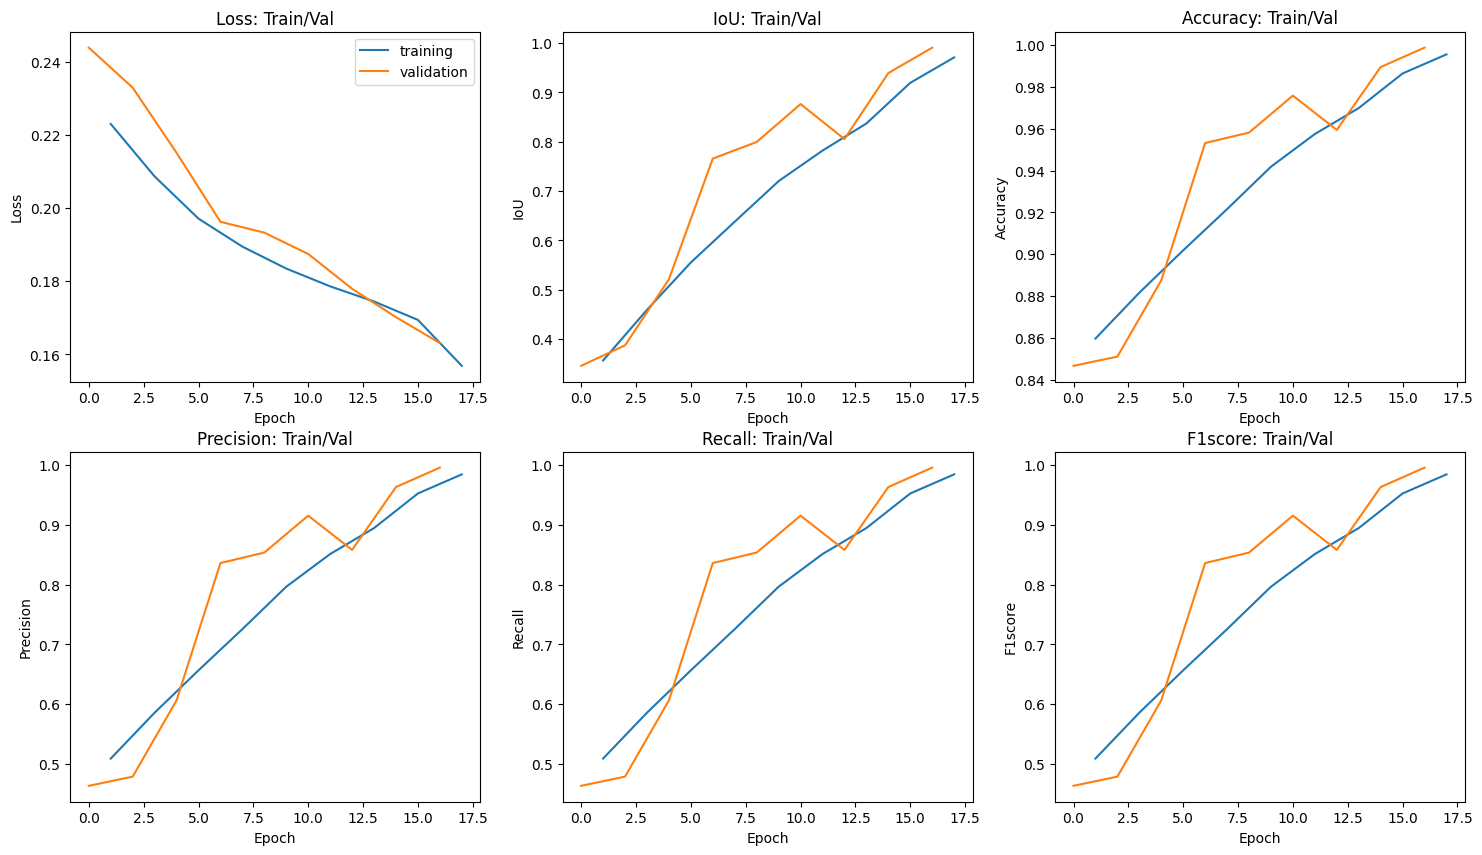

In [ ]:
metrics = pd.read_csv("./lightning_logs/landcover-classification-log/version_0/metrics.csv")
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(18, 10))

print("\n=================================================================== Hybrid Model ====================================================================\n")

axes = [ax1, ax2, ax3, ax4, ax5, ax6]
names = ['Loss', 'IoU', 'Accuracy', 'Precision', 'Recall', 'F1score']
for axis, name in zip(axes, names):
    axis.plot(metrics[f'train/{name}'].dropna())
    axis.plot(metrics[f'val/{name}'].dropna())
    axis.set_title(f'{name}: Train/Val')
    axis.set_ylabel(name)
    axis.set_xlabel('Epoch')
    ax1.legend(['training', 'validation'], loc="upper right")




=================================================================== Base Model ==============================================================



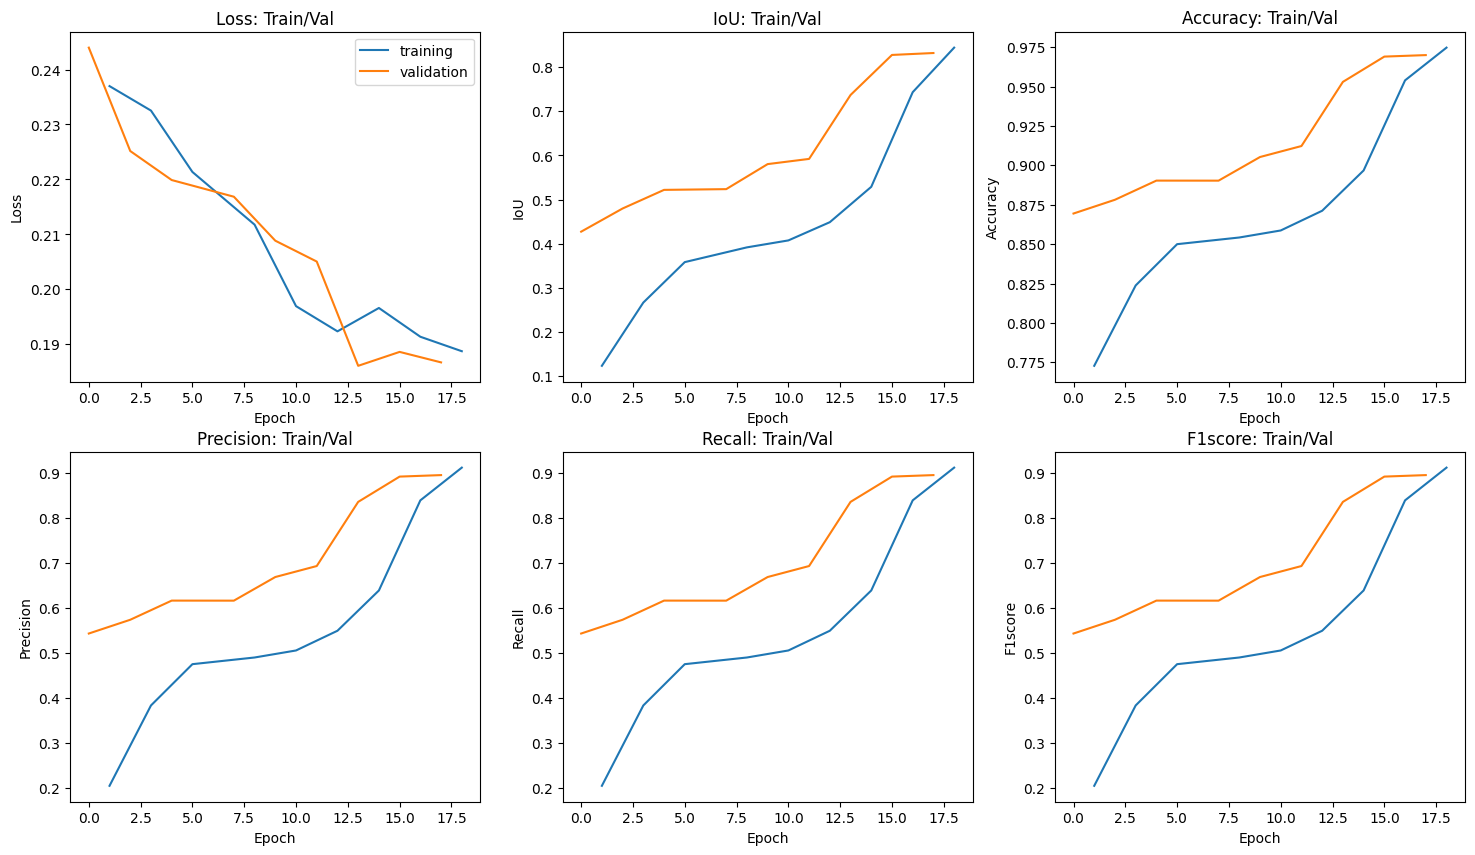

In [ ]:
metrics = pd.read_csv("./lightning_logs/landcover-classification-log1/version_0/metrics.csv")
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(18, 10))

axes = [ax1, ax2, ax3, ax4, ax5, ax6]
names = ['Loss', 'IoU', 'Accuracy', 'Precision', 'Recall', 'F1score']

print("\n=================================================================== Base Model ==============================================================\n")

for axis, name in zip(axes, names):
    axis.plot(metrics[f'train/{name}'].dropna())
    axis.plot(metrics[f'val/{name}'].dropna())
    axis.set_title(f'{name}: Train/Val')
    axis.set_ylabel(name)
    axis.set_xlabel('Epoch')
    ax1.legend(['training', 'validation'], loc="upper right")

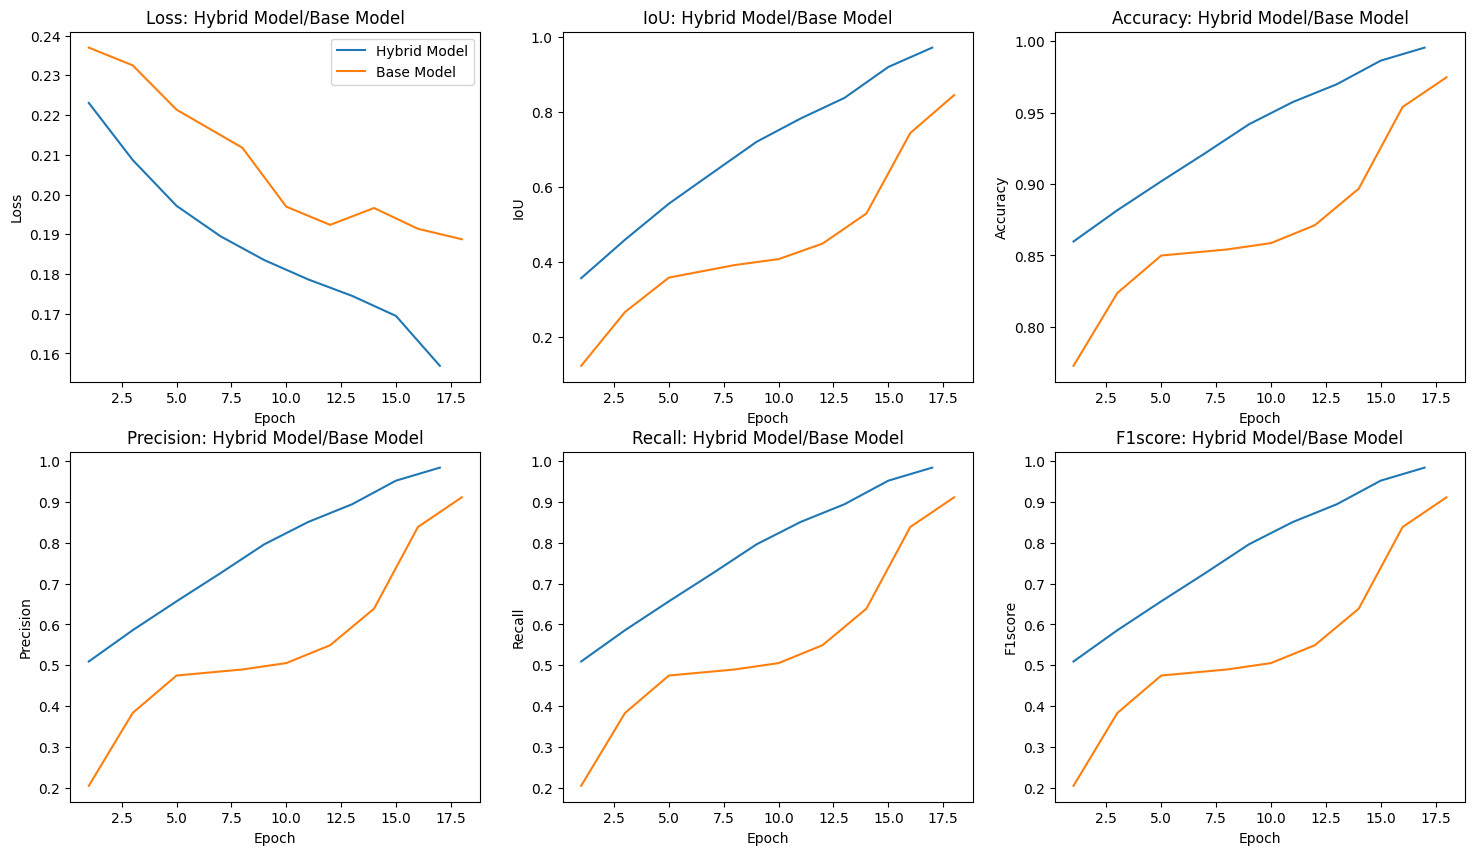

In [ ]:
metrics1 = pd.read_csv("./lightning_logs/landcover-classification-log/version_0/metrics.csv")
metrics2 = pd.read_csv("./lightning_logs/landcover-classification-log1/version_0/metrics.csv")
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(18, 10))

axes = [ax1, ax2, ax3, ax4, ax5, ax6]
names = ['Loss', 'IoU', 'Accuracy', 'Precision', 'Recall', 'F1score']

for axis, name in zip(axes, names):
    axis.plot(metrics1[f'train/{name}'].dropna())
    axis.plot(metrics2[f'train/{name}'].dropna())
    axis.set_title(f'{name}: Hybrid Model/Base Model')
    axis.set_ylabel(name)
    axis.set_xlabel('Epoch')
    ax1.legend(['Hybrid Model', 'Base Model'], loc="upper right")